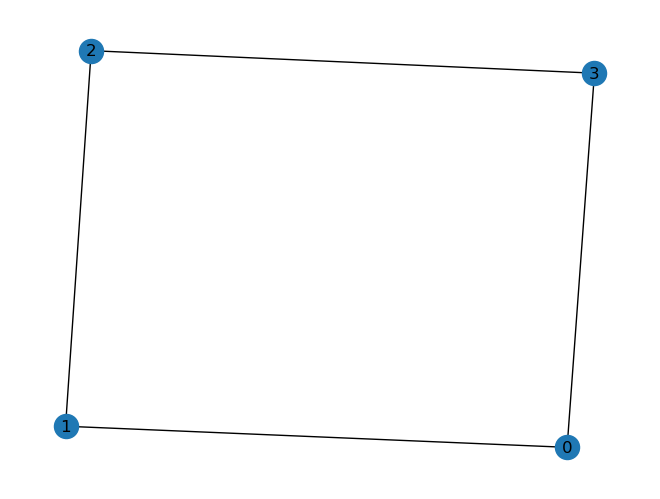

In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

graph_state = nx.Graph()
graph_state.add_nodes_from([0, 1, 2, 3])
#graph_state.add_edges_from([[0, 1], [0, 3], [1, 2], [2, 4], [3, 4]])
#graph_state.add_edges_from([(0, 2), (0, 3), (1, 2), (1, 3)])
graph_state.add_edges_from([(0, 1), (0, 3), (2, 1), (2, 3)])

nx.draw(graph_state, with_labels=True)

In [8]:
class Algorithm:
    def __init__(self, state:nx.graph):
        """
        Initializes X/Z as an NxN where N is the number of photons, automatically runs the height function 
        and adds emitters to make X/Z an MxM where M is the number of photons + number of emitters.
        """
        self.num_photons = len(state)
        self.dim = self.num_photons
        self.X = np.identity(self.num_photons, int)
        self.Z = nx.adjacency_matrix(state).todense()
        self.S = np.ones(self.num_photons, int)
        self.rref()

        self.num_emitters = max(self.height())
        self.dim = self.num_photons + self.num_emitters
        self.X = np.pad(self.X, (0, self.num_emitters), mode='constant')
        self.Z = np.pad(self.Z, (0, self.num_emitters), mode='constant')
        self.S = np.pad(self.S, (0, self.num_emitters), mode='constant')
        for i in range(self.num_photons, self.dim):
            self.Z[i][i] = 1
            self.S[i] = 1
        

    def __str__(self):
        """
        Prints out the individual Tableus.
        """
        return "X Tableu\n" + str(self.X) + "\n\nZ Tableu\n" + str(self.Z) + "\n\nS Tableu\n" + str(self.S)

    def stabilizers(self, formatted:bool):
        """
        Determines what the stabilizers look like as Pauli strings and prints them.
        'Formatted' determines if the stabilizers are printed as a matrix like object.
        """
        stabilizers = []
        for i in range(self.dim):
            i_stabilizer = ""
            for j in range(self.dim):
                if self.X[i][j] + self.Z[i][j] == 2:
                    i_stabilizer += "Y"
                elif self.X[i][j] == 1:
                    i_stabilizer += "X"
                elif self.Z[i][j] == 1:
                    i_stabilizer += "Z"
                else:
                    i_stabilizer += "I"
            stabilizers.append(i_stabilizer)
        if formatted:
            for i in range(self.dim):
                print(self.S[i], stabilizers[i], end='\n')
        else:
            print(stabilizers)
    
    def hadamard(self, qubit:int):
        """
        Performs a hadamard gate on a specified qubit by performing a bit flip on X/Z Paulis and 
        a phase change on Y Paulis
        """
        for i in range(self.dim):
            if self.X[i][qubit] + self.Z[i][qubit] == 1:
                self.X[i][qubit] = (self.X[i][qubit] + 1) % 2 
                self.Z[i][qubit] = (self.Z[i][qubit] + 1) % 2
            elif self.X[i][qubit] + self.Z[i][qubit] == 2:
                self.S[i] *= -1
    
    def phase(self, qubit:int):
        for i in range(self.dim):
            self.Z[i][qubit] = (self.Z[i][qubit] + self.X[i][qubit]) % 2
            if self.Z[i][qubit] + self.X[i][qubit] == 2:
                self.S[i] *= -1

    def cnot(self, control:int, target:int):
        """
        Performs a cnot gate between a control and target qubit by adding the X control to the X target
        and adding the Z target to the Z control, also checks for special phase change case.
        """
        for i in range(self.dim):
            if self.X[i][control] == self.X[i][target] == self.Z[i][control] == self.Z[i][target] == 1:
                self.S[i] *= -1
            self.X[i][target] = (self.X[i][control] + self.X[i][target]) % 2
            self.Z[i][control] = (self.Z[i][control] + self.Z[i][target]) % 2
            if self.X[i][control] == self.X[i][target] == self.Z[i][control] == self.Z[i][target] == 1:
                self.S[i] *= -1

    def rref(self):
        """
        Row reduces the tableus to be in RREF form
        """
        index = 0
        row = 0

        while row < self.dim and index < self.dim:
            x_column = self.X[:, index]
            z_column = self.Z[:, index]
            num_x, num_y, num_z = 0, 0, 0

            #Removes additional paulis of the same type
            for i in range(row, self.dim):
                if x_column[i] == 1 and z_column[i] == 0:
                    if num_x == 0:
                        first_x = i
                    num_x += 1
                    if num_x == 2:
                        self.X[i] = np.mod(np.add(self.X[first_x], self.X[i]), 2)
                        self.Z[i] = np.mod(np.add(self.Z[first_x], self.Z[i]), 2)
                        num_x -= 1
                if x_column[i] == 1 and z_column[i] == 1:
                    if num_y == 0:
                        first_y = i
                    num_y += 1
                    if num_y == 2:
                        self.X[i] = np.mod(np.add(self.X[first_y], self.X[i]), 2)
                        self.Z[i] = np.mod(np.add(self.Z[first_y], self.Z[i]), 2)
                        num_y -= 1
                if x_column[i] == 0 and z_column[i] == 1:
                    if num_z == 0:
                        first_z = i
                    num_z += 1
                    if num_z == 2:
                        self.X[i] = np.mod(np.add(self.X[first_z], self.X[i]), 2)
                        self.Z[i] = np.mod(np.add(self.Z[first_z], self.Z[i]), 2)
                        num_z -= 1

            num_pauli = num_x + num_y + num_z
            xz_column = np.add(x_column, z_column)

            if num_pauli == 1:
                first = np.where(xz_column[row:] >= 1)[0][0]
                self.X[[row, row+first]] = self.X[[row+first, row]]
                self.Z[[row, row+first]] = self.Z[[row+first, row]]
                
                row += 1

            elif num_pauli == 2:
                x_index = np.where(x_column[row:] == 1)[0]
                z_index = np.where(z_column[row:] == 1)[0]
                if len(x_index) == 2:
                    first = x_index[0]
                    second = x_index[1]
                    print('y')
                elif len(z_index) == 2:
                    first = z_index[0]
                    second = z_index[1]
                    print('y')
                else:
                    first = x_index[0]
                    second = z_index[0]
                self.X[[row, row+first]] = self.X[[row+first, row]]
                self.Z[[row, row+first]] = self.Z[[row+first, row]]
                self.X[[row+1, row+second]] = self.X[[row+second, row+1]]
                self.Z[[row+1, row+second]] = self.Z[[row+second, row+1]]

                row += 2

            elif num_pauli == 3:
                y_index = np.where(xz_column == 2)[0][0]
                xz_index = np.where(xz_column == 2)[0]
            
            index += 1

    def height(self):
        heights = []
        ranks = []
        XZ = np.add(self.X, self.Z)
        for row in XZ:
            ranks.append(np.where(row >= 1)[0][0] + 1)
        for i in range(self.dim):
            height = self.dim - i - sum(j > i for j in ranks)
            heights.append(height)
        return heights

    def reverse_measurement(self, photon):
        trm_emitter = 0
        candidate_index = []
        XZ = np.add(self.X, self.Z)
        for i in range(self.dim):
            row = XZ[i][0:self.num_photons]
            if np.sum(row) == 0:
                candidate_index.append(i)

        for j in candidate_index:
            one_z = np.sum(self.Z[j][self.num_photons:self.dim]) == 1 and np.sum(self.X[j]) == 0
            if one_z:
                trm_emitter = np.where(self.Z[j] == 1)[0][0]
                break
        self.hadamard(trm_emitter)
        self.cnot(trm_emitter, photon)
        print("TRM")

    def emission(self, photon):
        XZ = np.add(self.X, self.Z)
        for i in range(self.dim):
            pauli_index = np.where(XZ[i] >= 1)[0]
            if len(pauli_index) == 2:
                if pauli_index[0] == photon and pauli_index[1] >= self.num_photons:
                    emitter = pauli_index[1]
                    for qubit in [photon, emitter]:
                        if self.X[i][qubit] == self.Z[i][qubit] == 1:
                            self.phase(qubit)
                        elif self.X[i][qubit] == 1:
                            self.hadamard(qubit)
                    self.cnot(emitter, photon)
                    break
        print("Absorption")
        try:
            self.temp_emitter = emitter
        except:
            self.temp_emitter = self.num_photons
        

    def run(self):
        running = True
        photon = self.num_photons - 1
        self.rref()
        while running:
            print("photon:", photon)
            heights = self.height()
            if heights[photon] > heights[photon + 1]:
                self.reverse_measurement(photon)
            self.emission(photon)

            z_column = self.Z[:, self.temp_emitter]
            for i in range(self.dim):
                if z_column[i] == 1 and i != self.temp_emitter:
                    self.Z[i] = np.mod(np.add(self.Z[i], self.Z[self.temp_emitter]), 2)
                    pass
            self.rref()
            if photon == 0:
                running = False
            photon -= 1
        


alg_state = Algorithm(graph_state)
alg_state.run()
print('')
alg_state.stabilizers(True)

photon: 3
TRM
Absorption
photon: 2
TRM
Absorption
photon: 1
Absorption
photon: 0
Absorption

1 ZIIIII
1 IZZIXX
1 IIZIXX
1 IIIZII
1 IIIIXX
1 IIIIZZ
